# Buscar conexão entre volume de tráfego e condições de pavimentos

## Materiais

Temos duas bases de dados disponíveis: 

1. Volume de tráfego em 2020 e 2021 (Trabalho/bases-de-dados/contagem-de-trafego/contagem-de-trafego-pq)
2. Condições dos pavimentos em 2020 e 2021 (Trabalho/bases-de-dados/condicoes-pavimentos/condicoes-pavimentos-pq)

### Descrição das variáveis de volume de tráfego
- Ano: Ano da contagem de tráfego (2020 ou 2021)
- Codigo_Pavimento: Código do pavimento
- Classificacao: Classificação do pavimento (Ex: Rodovia, Avenida, etc)
- Superficie: Tipo de superfície do pavimento (Ex: Asfalto, Concreto, etc)
- Extensao_Total: Extensão total do pavimento em km
- VMDA_TOTAL_Media: Volume Médio Diário Anual total médio
- Total: Total de veículos contados no ano

## DICIONÁRIO DE DADOS de condições do pavimento -

ÍNDICE DE CONSERVAÇÃO E MANUTENÇÃO - ICM

| Campo | Tipo | Formato | Descrição |
|---|---|---|---|
| Contrato | Alfanumérico | NN NNNNN/NNNN | Refere-se ao número do contrato de serviço |
| UF | Texto | XX | Refere-se ao Estado da Federação que o equipamento está instalado. Indicado pela sigla da Unidade em formato XX. Ex: AL |
| Rodovia | Alfanumérico | XX-NNN | Refere-se a rodovia em análise em formato XX-NNN. Ex: BR-116 |
| Km inicial | Numérico | NNN,NNN | Refere-se ao km da rodovia onde inicia-se a análise, indicado em formato NNN,NNN de número com até 3 algarismos e 3 decimais, separados por vírgula. Ex: 485,140 |
| Km final | Numérico | NNN,NNN | Refere-se ao km da rodovia onde finaliza-se a análise, indicado em formato NNN,NNN de número com até 3 algarismos e 3 decimais, separados por vírgula. Ex: 485,140 |
| Extensão | Numérico | NNN,NNN | Refere-se à diferença entre o km final e o km inicial |
| Data | Data | DD/MM/AAAA | Trata-se da data em que foi realizada a análise mais recente, no formato Dia, Mês, Ano. Ex.: 01/11/2020 |
| Latitude | Numérico | - | Indica a latitude da localização do equipamento, com coordenada geográfica. Indicado em formato XXºXX'XX,XX''X, onde todos são números exceto o último, que indica o hemisfério N (Norte) ou S (Sul). Ex: 13°31'10,91"S |
| Longitude | Numérico | - | Indica a longitude da localização do equipamento, com coordenada geográfica. Indicado em formato XXºXX'XX,XX''O, onde todos são números exceto o último, que indica estar na região Oeste do Meridiano de Greenwich. Ex: 49°11'09,99"O |
| ICC | Numérico | NN,NNN | Índice de Condição da Conservação |
| ICP | Numérico | NN,NNN | Índice de Condição do Pavimento |
| ICM | Numérico | NN,NNN | Índice de Condição de Manutenção. Valores de referência: ICM < 30 = BOM; 30 < ICM < 50 = REGULAR; 50 < ICM < 70 = RUIM; ICM > 70 = PÉSSIMO |

https://www.gov.br/dnit/pt-br/central-de-conteudos/atos-normativos/tipo/resolucoes/resolucao-5-2022-dir-ba-080-de-29-04-2022.pdf



In [1]:
################################################################################
# Definindo um caminho personalizado para bibliotecas R
################################################################################
# Exemplo de caminho: pode ser uma pasta dentro do seu diretório home
# Lembre-se que o R pode adicionar subdiretórios específicos da versão/arquitetura
meu_caminho_biblioteca <- "~/R/library"

# Define a variável de ambiente R_LIBS_USER para a sessão atual
Sys.setenv(R_LIBS_USER = meu_caminho_biblioteca)

# Verifica o valor da variável de ambiente
Sys.getenv("R_LIBS_USER")

# Mostra todos os caminhos de biblioteca que o R está usando
# O seu novo caminho deve aparecer aqui, geralmente como o primeiro da lista.
.libPaths()

[1] "~/R/library"

[1] "/usr/local/lib/R/site-library" "/usr/local/lib/R/library"     
[3] "/home/vscode/R/library"

In [ ]:
################################################################################
#               INSTALAÇÃO E CARREGAMENTO DE PACOTES NECESSÁRIOS               #
################################################################################

# Pacotes utilizados
pacotes <- c("tidyverse", #carregar outros pacotes do R
             "knitr", "kableExtra", #formatação de tabelas
             "arrow","duckdb") # parquet e banco de dados

if(sum(as.numeric(!pacotes %in% installed.packages())) != 0){
  instalador <- pacotes[!pacotes %in% installed.packages()]
  for(i in 1:length(instalador)) {
    install.packages(instalador, dependencies = T, lib = meu_caminho_biblioteca)
    break()}
  sapply(pacotes, require, character = T, lib = meu_caminho_biblioteca) 
} else {
  sapply(pacotes, require, character = T, lib = meu_caminho_biblioteca) 
}

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: knitr

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘knitr’”
Loading required package: kableExtra


Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows


Loading required package: arrow


Attaching package: ‘arrow’


The following object is masked from ‘package:lubridate’:

 

tidyverse      knitr kableExtra      arrow     duckdb 
      TRUE      FALSE       TRUE       TRUE       TRUE

In [13]:
# Vamos ler as fontes de dados em formato Parquet

# Abrir dataset particionado de condições de pavimento
df_pavimentos <- open_dataset(
  "Trabalho/bases-de-dados/condicoes-de-pavimento/condicoes-de-pavimento-pq/"
)
# Verificar esquema do dataset
cat("\n=== ESQUEMA DO DATASET DE PAVIMENTOS ===\n")
print(df_pavimentos$schema)
# Abrir dataset particionado de contagem de tráfego
df_trafego <- open_dataset(
  "Trabalho/bases-de-dados/contagem-de-trafego/contagem-de-trafego-pq/"
)
# Verificar esquema do dataset
cat("\n=== ESQUEMA DO DATASET DE TRÁFEGO ===\n")
print(df_trafego$schema)


=== ESQUEMA DO DATASET DE PAVIMENTOS ===
Schema
Contrato: string
UF: string
Rodovia: string
km.inicial: double
km.final: double
Extensao.km: double
Data: date32[day]
Latitude: double
Longitude: double
ICC: double
ICP: double
ICM: double
Classificacao_ICM: string
Ano: int32

See $metadata for additional Schema metadata

=== ESQUEMA DO DATASET DE TRÁFEGO ===
Schema
ID: int32
vl_codigo: string
UF: string
REGIAO: string
RELEVO_PRE: string
VELOCIDADE: double
CODIGO_BR: int32
EXTENSAO: double
SUPERFICIE: string
JURISDICAO: string
TIPO_LINK: string
CLASSIFICACAO: string
GEH: string
VMDA_C: double
VMDA_D: double
VMDA_TOTAL: double
CODIGO_SNV.SRE: string
Ano: int32

See $metadata for additional Schema metadata
Schema
Contrato: string
UF: string
Rodovia: string
km.inicial: double
km.final: double
Extensao.km: double
Data: date32[day]
Latitude: double
Longitude: double
ICC: double
ICP: double
ICM: double
Classificacao_ICM: string
Ano: int32

See $metadata for additional Schema metadata

=== ESQU

In [14]:
################################################################################
#     Ler os datasets Parquet particionados com duckdb e realizar consultas    #
################################################################################
# Alternativa: executar SQL diretamente no dataset Parquet
library(duckdb)
# Conectar DuckDB (in-memory, zero configuração)
con <- dbConnect(duckdb::duckdb())
# Abrir dataset Parquet particionado
ds <- open_dataset("Trabalho/bases-de-dados/condicoes-de-pavimento/condicoes-de-pavimento-pq/")
# Registrar como tabela virtual no DuckDB
duckdb_register(con, "dados", ds)
# SELECT COUNT(*), Ano GROUP BY Ano (SQL puro!)
resultado <- dbGetQuery(con, "
    SELECT *
    FROM dados 
    LIMIT 5
")
print("cabeçalho do dataset de pavimentos:")
print(resultado)

con2 <- dbConnect(duckdb::duckdb())
ds2 <- open_dataset("Trabalho/bases-de-dados/contagem-de-trafego/contagem-de-trafego-pq/")
duckdb_register(con2, "dados_trafego", ds2)
resultado2 <- dbGetQuery(con2, "
    SELECT *
    FROM dados_trafego 
    LIMIT 5
")
print("cabeçalho do dataset de tráfego:")
print(resultado2)

# Fechar conexão
dbDisconnect(con, shutdown = TRUE)
dbDisconnect(con2, shutdown = TRUE)


[1] "cabeçalho do dataset de pavimentos:"
       Contrato UF Rodovia km.inicial km.final Extensao.km       Data  Latitude
1 01 00583/2018 AM  BR-230       2132      212         1.2 2020-11-30 -71991363
2 01 00583/2018 AM  BR-230        212      211         1.0 2020-11-30 -71949552
3 01 00583/2018 AM  BR-230        211      210         1.0 2020-11-30 -71949552
4 01 00583/2018 AM  BR-230        210      209         1.0 2020-11-30 -71949552
5 01 00583/2018 AM  BR-230        209      208         1.0 2020-11-30 -71949552
   Longitude ICC ICP ICM Classificacao_ICM  Ano
1 -598909876  80  70  73           PÉSSIMO 2020
2 -598855125  80  70  73           PÉSSIMO 2020
3 -598855125  80  45 555           PÉSSIMO 2020
4 -598855125  80  70  73           PÉSSIMO 2020
5 -598855125  80  45 555           PÉSSIMO 2020
       Contrato UF Rodovia km.inicial km.final Extensao.km       Data  Latitude
1 01 00583/2018 AM  BR-230       2132      212         1.2 2020-11-30 -71991363
2 01 00583/2018 AM  BR-230    


=== ESQUEMA DO DATASET DE PAVIMENTOS ===
Schema
Contrato: string
UF: string
Rodovia: string
km.inicial: double
km.final: double
Extensao.km: double
Data: date32[day]
Latitude: double
Longitude: double
ICC: double
ICP: double
ICM: double
Classificacao_ICM: string
Ano: int32

See $metadata for additional Schema metadata
Schema
Contrato: string
UF: string
Rodovia: string
km.inicial: double
km.final: double
Extensao.km: double
Data: date32[day]
Latitude: double
Longitude: double
ICC: double
ICP: double
ICM: double
Classificacao_ICM: string
Ano: int32

See $metadata for additional Schema metadata

=== DIMENSÕES DO DATASET ===
Linhas: 75985 
Colunas: 14 


=== DIMENSÕES DO DATASET ===
Linhas: 75985 
Colunas: 14 

=== ESTRUTURA DOS DADOS ===
=== ESTRUTURA DOS DADOS ===


tibble [75,985 × 14] (S3: tbl_df/tbl/data.frame)
 $ Contrato         : chr [1:75985] "01 00583/2018" "01 00583/2018" "01 00583/2018" "01 00583/2018" ...
 $ UF               : chr [1:75985] "AM" "AM" "AM" "AM" ...
 $ Rodovia          : chr [1:75985] "BR-230" "BR-230" "BR-230" "BR-230" ...
 $ km.inicial       : num [1:75985] 2132 212 211 210 209 ...
 $ km.final         : num [1:75985] 212 211 210 209 208 214 215 198 199 200 ...
 $ Extensao.km      : num [1:75985] 1.2 1 1 1 1 0.8 1 0.3 1 1 ...
 $ Data             : Date[1:75985], format: "2020-11-30" "2020-11-30" ...
 $ Latitude         : num [1:75985] -71991363 -71949552 -71949552 -71949552 -71949552 ...
 $ Longitude        : num [1:75985] -5.99e+08 -5.99e+08 -5.99e+08 -5.99e+08 -5.99e+08 ...
 $ ICC              : num [1:75985] 80 80 80 80 80 85 85 375 30 25 ...
 $ ICP              : num [1:75985] 70 70 45 70 45 70 70 325 25 25 ...
 $ ICM              : num [1:75985] 73 73 555 73 555 745 745 34 265 25 ...
 $ Classificacao_ICM: chr [1:759

<table class="table table-striped" style="margin-left: auto; margin-right: auto;">
<caption>Estatísticas descritivas dos índices de pavimento por ano</caption>
 <thead>
  <tr>
   <th style="text-align:right;"> Ano </th>
   <th style="text-align:right;"> N_Registros </th>
   <th style="text-align:right;"> ICC_Media </th>
   <th style="text-align:right;"> ICC_Mediana </th>
   <th style="text-align:right;"> ICC_DesvPad </th>
   <th style="text-align:right;"> ICP_Media </th>
   <th style="text-align:right;"> ICP_Mediana </th>
   <th style="text-align:right;"> ICP_DesvPad </th>
   <th style="text-align:right;"> ICM_Media </th>
   <th style="text-align:right;"> ICM_Mediana </th>
   <th style="text-align:right;"> ICM_DesvPad </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:right;"> 2020 </td>
   <td style="text-align:right;"> 34571 </td>
   <td style="text-align:right;"> 188.01 </td>
   <td style="text-align:right;"> 50 </td>
   <td style="text-align:right;"> 194.80 </td>
   <t


=== DISTRIBUIÇÃO DO ICC (Índice de Condição da Conservação) ===


<table class="table table-striped" style="margin-left: auto; margin-right: auto;">
<caption>Distribuição de ICC por ano</caption>
 <thead>
  <tr>
   <th style="text-align:right;"> Ano </th>
   <th style="text-align:right;"> N_Total </th>
   <th style="text-align:right;"> N_NA </th>
   <th style="text-align:right;"> N_Válido </th>
   <th style="text-align:right;"> Min </th>
   <th style="text-align:right;"> Q1 </th>
   <th style="text-align:right;"> Mediana </th>
   <th style="text-align:right;"> Media </th>
   <th style="text-align:right;"> Q3 </th>
   <th style="text-align:right;"> Max </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:right;"> 2020 </td>
   <td style="text-align:right;"> 34571 </td>
   <td style="text-align:right;"> 0 </td>
   <td style="text-align:right;"> 34571 </td>
   <td style="text-align:right;"> 20 </td>
   <td style="text-align:right;"> 25 </td>
   <td style="text-align:right;"> 50 </td>
   <td style="text-align:right;"> 188.01 </td>
   <td style


=== DISTRIBUIÇÃO DO ICP (Índice de Condição do Pavimento) ===


<table class="table table-striped" style="margin-left: auto; margin-right: auto;">
<caption>Distribuição de ICP por ano</caption>
 <thead>
  <tr>
   <th style="text-align:right;"> Ano </th>
   <th style="text-align:right;"> N_Total </th>
   <th style="text-align:right;"> N_NA </th>
   <th style="text-align:right;"> N_Válido </th>
   <th style="text-align:right;"> Min </th>
   <th style="text-align:right;"> Q1 </th>
   <th style="text-align:right;"> Mediana </th>
   <th style="text-align:right;"> Media </th>
   <th style="text-align:right;"> Q3 </th>
   <th style="text-align:right;"> Max </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:right;"> 2020 </td>
   <td style="text-align:right;"> 34571 </td>
   <td style="text-align:right;"> 0 </td>
   <td style="text-align:right;"> 34571 </td>
   <td style="text-align:right;"> 0 </td>
   <td style="text-align:right;"> 5 </td>
   <td style="text-align:right;"> 25 </td>
   <td style="text-align:right;"> 87.24 </td>
   <td style="t


=== DISTRIBUIÇÃO DO ICM (Índice de Condição de Manutenção) ===
Valores de referência: ICM < 30 = BOM; 30 ≤ ICM < 50 = REGULAR; 50 ≤ ICM < 70 = RUIM; ICM ≥ 70 = PÉSSIMO

Valores de referência: ICM < 30 = BOM; 30 ≤ ICM < 50 = REGULAR; 50 ≤ ICM < 70 = RUIM; ICM ≥ 70 = PÉSSIMO



<table class="table table-striped" style="margin-left: auto; margin-right: auto;">
<caption>Distribuição de ICM por ano</caption>
 <thead>
  <tr>
   <th style="text-align:right;"> Ano </th>
   <th style="text-align:right;"> N_Total </th>
   <th style="text-align:right;"> N_NA </th>
   <th style="text-align:right;"> N_Válido </th>
   <th style="text-align:right;"> Min </th>
   <th style="text-align:right;"> Q1 </th>
   <th style="text-align:right;"> Mediana </th>
   <th style="text-align:right;"> Media </th>
   <th style="text-align:right;"> Q3 </th>
   <th style="text-align:right;"> Max </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:right;"> 2020 </td>
   <td style="text-align:right;"> 34571 </td>
   <td style="text-align:right;"> 0 </td>
   <td style="text-align:right;"> 34571 </td>
   <td style="text-align:right;"> 6 </td>
   <td style="text-align:right;"> 71 </td>
   <td style="text-align:right;"> 465 </td>
   <td style="text-align:right;"> 1453.09 </td>
   <td styl


=== GRÁFICO 1: Distribuição de ICC por Ano ===

=== GRÁFICO 2: Distribuição de ICP por Ano ===

=== GRÁFICO 2: Distribuição de ICP por Ano ===


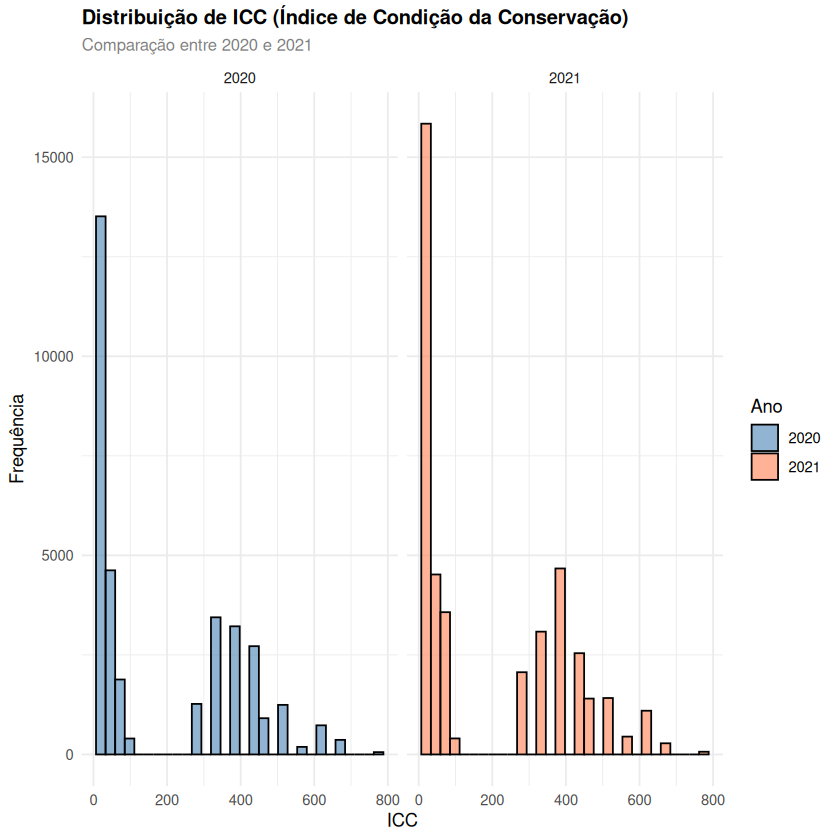


=== GRÁFICO 3: Distribuição de ICM por Ano ===


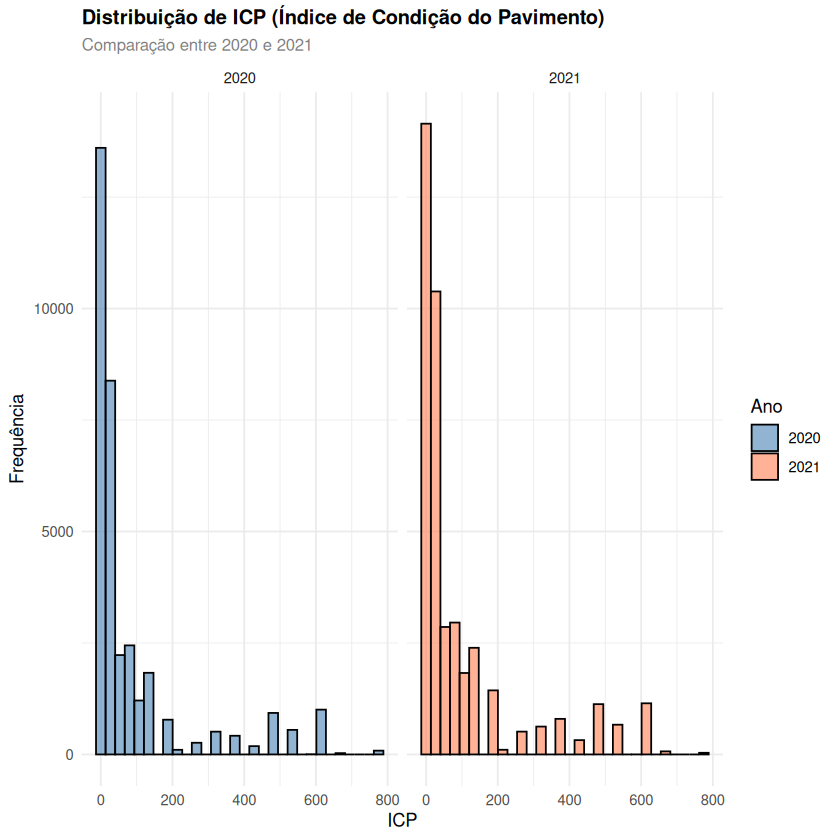


=== VARIAÇÃO DOS ÍNDICES (2020 → 2021) ===
# A tibble: 2 × 7
    Ano ICC_Media ICP_Media ICM_Media ICC_Variacao ICP_Variacao ICM_Variacao
  <int>     <dbl>     <dbl>     <dbl>        <dbl>        <dbl>        <dbl>
1  2020      188.      87.2     1453.        NA            NA           NA  
2  2021      191.      94.9     1484.         2.77          7.7         31.1

✓ Análise de distribuição dos índices ICC, ICP e ICM concluída!
# A tibble: 2 × 7
    Ano ICC_Media ICP_Media ICM_Media ICC_Variacao ICP_Variacao ICM_Variacao
  <int>     <dbl>     <dbl>     <dbl>        <dbl>        <dbl>        <dbl>
1  2020      188.      87.2     1453.        NA            NA           NA  
2  2021      191.      94.9     1484.         2.77          7.7         31.1

✓ Análise de distribuição dos índices ICC, ICP e ICM concluída!


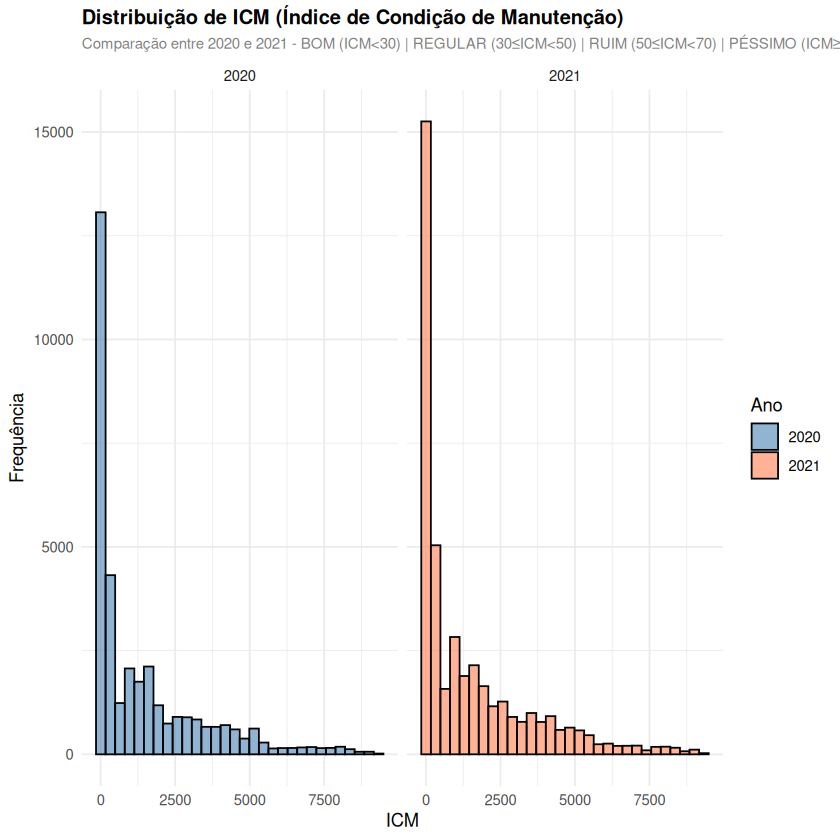

In [10]:
# Analise de distribuição de ICC, ICP e ICM por ano
# Abrir dataset Parquet particionado
################################################################################
#       ANÁLISE DE DISTRIBUIÇÃO DE ICC, ICP E ICM POR ANO                     #
################################################################################

# Carregar bibliotecas necessárias
library(tidyverse)
library(arrow)
library(duckdb)
library(kableExtra)

# Abrir dataset Parquet particionado de condições de pavimento
ds_pavimentos <- open_dataset(
  "Trabalho/bases-de-dados/condicoes-de-pavimento/condicoes-de-pavimento-pq/"
)

cat("\n=== ESQUEMA DO DATASET DE PAVIMENTOS ===\n")
print(ds_pavimentos$schema)

################################################################################
#              ANÁLISE EXPLORATÓRIA - ÍNDICES DE PAVIMENTO                     #
################################################################################

# Carregar dados na memória para análise com dplyr
df_pavimentos <- ds_pavimentos %>%
  collect()

cat("\n=== DIMENSÕES DO DATASET ===\n")
cat("Linhas:", nrow(df_pavimentos), "\n")
cat("Colunas:", ncol(df_pavimentos), "\n\n")

# Estrutura dos dados
cat("=== ESTRUTURA DOS DADOS ===\n")
str(df_pavimentos)

# Primeiras linhas
cat("\n=== PRIMEIRAS 6 LINHAS ===\n")
print(head(df_pavimentos, 6))

################################################################################
#         ESTATÍSTICAS DESCRITIVAS DOS ÍNDICES (ICC, ICP, ICM)                #
################################################################################

cat("\n=== ESTATÍSTICAS DESCRITIVAS POR ANO ===\n")
df_pavimentos %>%
  group_by(Ano) %>%
  summarise(
    N_Registros = n(),
    ICC_Media = mean(ICC, na.rm = TRUE),
    ICC_Mediana = median(ICC, na.rm = TRUE),
    ICC_DesvPad = sd(ICC, na.rm = TRUE),
    ICP_Media = mean(ICP, na.rm = TRUE),
    ICP_Mediana = median(ICP, na.rm = TRUE),
    ICP_DesvPad = sd(ICP, na.rm = TRUE),
    ICM_Media = mean(ICM, na.rm = TRUE),
    ICM_Mediana = median(ICM, na.rm = TRUE),
    ICM_DesvPad = sd(ICM, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  kable(
    caption = "Estatísticas descritivas dos índices de pavimento por ano",
    digits = 2
  ) %>%
  kable_styling(bootstrap_options = "striped", full_width = TRUE)

################################################################################
#              DISTRIBUIÇÃO DETALHADA POR ÍNDICE E ANO                         #
################################################################################

# ICC - Índice de Condição da Conservação
cat("\n=== DISTRIBUIÇÃO DO ICC (Índice de Condição da Conservação) ===\n")
df_pavimentos %>%
  group_by(Ano) %>%
  summarise(
    N_Total = n(),
    N_NA = sum(is.na(ICC)),
    N_Válido = sum(!is.na(ICC)),
    Min = min(ICC, na.rm = TRUE),
    Q1 = quantile(ICC, 0.25, na.rm = TRUE),
    Mediana = median(ICC, na.rm = TRUE),
    Media = mean(ICC, na.rm = TRUE),
    Q3 = quantile(ICC, 0.75, na.rm = TRUE),
    Max = max(ICC, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  kable(caption = "Distribuição de ICC por ano", digits = 2) %>%
  kable_styling(bootstrap_options = "striped")

# ICP - Índice de Condição do Pavimento
cat("\n=== DISTRIBUIÇÃO DO ICP (Índice de Condição do Pavimento) ===\n")
df_pavimentos %>%
  group_by(Ano) %>%
  summarise(
    N_Total = n(),
    N_NA = sum(is.na(ICP)),
    N_Válido = sum(!is.na(ICP)),
    Min = min(ICP, na.rm = TRUE),
    Q1 = quantile(ICP, 0.25, na.rm = TRUE),
    Mediana = median(ICP, na.rm = TRUE),
    Media = mean(ICP, na.rm = TRUE),
    Q3 = quantile(ICP, 0.75, na.rm = TRUE),
    Max = max(ICP, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  kable(caption = "Distribuição de ICP por ano", digits = 2) %>%
  kable_styling(bootstrap_options = "striped")

# ICM - Índice de Condição de Manutenção
cat("\n=== DISTRIBUIÇÃO DO ICM (Índice de Condição de Manutenção) ===\n")
cat("Valores de referência: ICM < 30 = BOM; 30 ≤ ICM < 50 = REGULAR; 50 ≤ ICM < 70 = RUIM; ICM ≥ 70 = PÉSSIMO\n\n")
df_pavimentos %>%
  group_by(Ano) %>%
  summarise(
    N_Total = n(),
    N_NA = sum(is.na(ICM)),
    N_Válido = sum(!is.na(ICM)),
    Min = min(ICM, na.rm = TRUE),
    Q1 = quantile(ICM, 0.25, na.rm = TRUE),
    Mediana = median(ICM, na.rm = TRUE),
    Media = mean(ICM, na.rm = TRUE),
    Q3 = quantile(ICM, 0.75, na.rm = TRUE),
    Max = max(ICM, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  kable(caption = "Distribuição de ICM por ano", digits = 2) %>%
  kable_styling(bootstrap_options = "striped")

################################################################################
#                     VISUALIZAÇÕES - HISTOGRAMAS                              #
################################################################################

# Histograma comparativo ICC por ano
cat("\n=== GRÁFICO 1: Distribuição de ICC por Ano ===\n")
df_pavimentos %>%
  ggplot(aes(x = ICC, fill = as.factor(Ano))) +
  geom_histogram(bins = 30, alpha = 0.6, color = "black") +
  facet_wrap(~Ano) +
  scale_fill_manual(
    name = "Ano",
    values = c("2020" = "steelblue", "2021" = "coral")
  ) +
  labs(
    title = "Distribuição de ICC (Índice de Condição da Conservação)",
    x = "ICC",
    y = "Frequência",
    subtitle = "Comparação entre 2020 e 2021"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 12),
    plot.subtitle = element_text(size = 10, color = "gray50")
  )

# Histograma comparativo ICP por ano
cat("\n=== GRÁFICO 2: Distribuição de ICP por Ano ===\n")
df_pavimentos %>%
  ggplot(aes(x = ICP, fill = as.factor(Ano))) +
  geom_histogram(bins = 30, alpha = 0.6, color = "black") +
  facet_wrap(~Ano) +
  scale_fill_manual(
    name = "Ano",
    values = c("2020" = "steelblue", "2021" = "coral")
  ) +
  labs(
    title = "Distribuição de ICP (Índice de Condição do Pavimento)",
    x = "ICP",
    y = "Frequência",
    subtitle = "Comparação entre 2020 e 2021"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 12),
    plot.subtitle = element_text(size = 10, color = "gray50")
  )

# Histograma comparativo ICM por ano
cat("\n=== GRÁFICO 3: Distribuição de ICM por Ano ===\n")
df_pavimentos %>%
  ggplot(aes(x = ICM, fill = as.factor(Ano))) +
  geom_histogram(bins = 30, alpha = 0.6, color = "black") +
  facet_wrap(~Ano) +
  scale_fill_manual(
    name = "Ano",
    values = c("2020" = "steelblue", "2021" = "coral")
  ) +
  labs(
    title = "Distribuição de ICM (Índice de Condição de Manutenção)",
    x = "ICM",
    y = "Frequência",
    subtitle = "Comparação entre 2020 e 2021 - BOM (ICM<30) | REGULAR (30≤ICM<50) | RUIM (50≤ICM<70) | PÉSSIMO (ICM≥70)"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 12),
    plot.subtitle = element_text(size = 9, color = "gray50")
  )


################################################################################
#      RESUMO FINAL - MUDANÇAS DE 2020 PARA 2021                               #
################################################################################

cat("\n=== VARIAÇÃO DOS ÍNDICES (2020 → 2021) ===\n")

resumo_variacao <- df_pavimentos %>%
  group_by(Ano) %>%
  summarise(
    ICC_Media = mean(ICC, na.rm = TRUE),
    ICP_Media = mean(ICP, na.rm = TRUE),
    ICM_Media = mean(ICM, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  mutate(
    ICC_Variacao = round(ICC_Media - lag(ICC_Media), 3),
    ICP_Variacao = round(ICP_Media - lag(ICP_Media), 3),
    ICM_Variacao = round(ICM_Media - lag(ICM_Media), 3)
  )

print(resumo_variacao)

cat("\n✓ Análise de distribuição dos índices ICC, ICP e ICM concluída!\n")


In [12]:
# Código R, para a partir do df_pavimentos exportar CSV com os atributos: 
# Rodovia: string
# km.inicial: double
# km.final: double
# Extensao.km: double
# Latitude: double
# Longitude: double
# median(ICC): double
# median(ICP): double
# median(ICM): double
# Classificacao_ICM: string
# Ano: int32

################################################################################
#      EXPORTAR DATASET AGREGADO PARA CSV                                      #
################################################################################

# Preparar dataset com agregações por Rodovia e Ano
df_pavimentos_exportacao <- df_pavimentos %>%
  group_by(Rodovia, Ano) %>%
  summarise(
    km_inicial = first(na.omit(km.inicial)),
    km_final = last(na.omit(km.final)),
    Extensao_km = mean(Extensao.km, na.rm = TRUE),
    Latitude = mean(Latitude, na.rm = TRUE),
    Longitude = mean(Longitude, na.rm = TRUE),
    ICC_Mediana = median(ICC, na.rm = TRUE),
    ICP_Mediana = median(ICP, na.rm = TRUE),
    ICM_Mediana = median(ICM, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  # Recriar coluna de classificação ICM baseada na mediana
  mutate(
    Classificacao_ICM = case_when(
      ICM_Mediana < 30 ~ "BOM",
      ICM_Mediana >= 30 & ICM_Mediana < 50 ~ "REGULAR",
      ICM_Mediana >= 50 & ICM_Mediana < 70 ~ "RUIM",
      ICM_Mediana >= 70 ~ "PÉSSIMO",
      is.na(ICM_Mediana) ~ NA_character_
    )
  ) %>%
  # Reordenar e renomear colunas conforme especificado
  select(
    Rodovia,
    km_inicial,
    km_final,
    Extensao_km,
    Latitude,
    Longitude,
    ICC_Mediana,
    ICP_Mediana,
    ICM_Mediana,
    Classificacao_ICM,
    Ano
  ) %>%
  # Converter tipos de dados conforme especificação
  mutate(
    Rodovia = as.character(Rodovia),
    km_inicial = as.numeric(km_inicial),
    km_final = as.numeric(km_final),
    Extensao_km = as.numeric(Extensao_km),
    Latitude = as.numeric(Latitude),
    Longitude = as.numeric(Longitude),
    ICC_Mediana = as.numeric(ICC_Mediana),
    ICP_Mediana = as.numeric(ICP_Mediana),
    ICM_Mediana = as.numeric(ICM_Mediana),
    Classificacao_ICM = as.character(Classificacao_ICM),
    Ano = as.integer(Ano)
  ) %>%
  arrange(Ano, Rodovia)

################################################################################
#                    ESTATÍSTICAS DO DATASET EXPORTAÇÃO                        #
################################################################################

cat("\n=== RESUMO DO DATASET PARA EXPORTAÇÃO ===\n")
cat("Total de registros:", nrow(df_pavimentos_exportacao), "\n")
cat("Total de colunas:", ncol(df_pavimentos_exportacao), "\n\n")

cat("=== ESTRUTURA DOS DADOS ===\n")
str(df_pavimentos_exportacao)

cat("\n=== PRIMEIRAS 10 LINHAS ===\n")
print(head(df_pavimentos_exportacao, 10))

cat("\n=== DISTRIBUIÇÃO POR ANO E CLASSIFICAÇÃO ===\n")
df_pavimentos_exportacao %>%
  group_by(Ano, Classificacao_ICM) %>%
  summarise(
    Total = n(),
    Extensao_Media = mean(Extensao_km, na.rm = TRUE),
    ICM_Mediana_Media = mean(ICM_Mediana, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  kable(
    caption = "Resumo de agregações por Ano e Classificação ICM",
    digits = 2
  ) %>%
  kable_styling(bootstrap_options = "striped")

################################################################################
#                    EXPORTAR PARA CSV                                         #
################################################################################

# Caminho de saída
caminho_csv <- "Trabalho/bases-de-dados/condicoes-de-pavimento/pavimentos_agregado.csv"

# Exportar para CSV
write.csv(
  df_pavimentos_exportacao,
  file = caminho_csv,
  row.names = FALSE,
  fileEncoding = "UTF-8"
)

cat("\n✓ Dataset exportado com sucesso para CSV\n")
cat("   Caminho:", caminho_csv, "\n")
cat("   Total de linhas:", nrow(df_pavimentos_exportacao), "\n")
cat("   Total de colunas:", ncol(df_pavimentos_exportacao), "\n")

################################################################################
#                    VERIFICAÇÃO DO ARQUIVO EXPORTADO                          #
################################################################################

# Ler o arquivo para validação
df_verificacao <- read.csv(caminho_csv, fileEncoding = "UTF-8")

cat("\n=== VALIDAÇÃO DO ARQUIVO EXPORTADO ===\n")
cat("Dimensões:", nrow(df_verificacao), "linhas x", ncol(df_verificacao), "colunas\n\n")

cat("=== TIPOS DE DADOS APÓS IMPORTAÇÃO ===\n")
str(df_verificacao)

cat("\n=== AMOSTRA DO ARQUIVO EXPORTADO (Primeiras 5 linhas) ===\n")
print(head(df_verificacao, 5))

cat("\n=== SUMÁRIO ESTATÍSTICO ===\n")
summary(df_verificacao)

cat("\n✓ Validação do arquivo CSV concluída!\n")



=== RESUMO DO DATASET PARA EXPORTAÇÃO ===
Total de registros: 169 
Total de colunas: 11 

=== ESTRUTURA DOS DADOS ===
Total de registros: 169 
Total de colunas: 11 

=== ESTRUTURA DOS DADOS ===
tibble [169 × 11] (S3: tbl_df/tbl/data.frame)
 $ Rodovia          : chr [1:169] "BR-010" "BR-020" "BR-040" "BR-060" ...
 $ km_inicial       : num [1:169] 4349 4464 237 6829 5374 ...
 $ km_final         : num [1:169] 379 242 16 0 425 139 109 0 916 155 ...
 $ Extensao_km      : num [1:169] 0.998 0.998 0.976 0.991 0.985 ...
 $ Latitude         : num [1:169] -2.59e+08 -4.43e+08 -2.05e+08 -2.02e+08 -1.32e+08 ...
 $ Longitude        : num [1:169] -3.11e+08 -3.03e+08 -3.55e+08 -5.36e+08 -4.67e+08 ...
 $ ICC_Mediana      : num [1:169] 50 325 375 40 55 50 375 325 30 375 ...
 $ ICP_Mediana      : num [1:169] 25 20 425 5 5 32.5 20 25 40 75 ...
 $ ICM_Mediana      : num [1:169] 125 1275 555 645 825 ...
 $ Classificacao_ICM: chr [1:169] "PÉSSIMO" "PÉSSIMO" "PÉSSIMO" "PÉSSIMO" ...
 $ Ano              : int [

<table class="table table-striped" style="margin-left: auto; margin-right: auto;">
<caption>Resumo de agregações por Ano e Classificação ICM</caption>
 <thead>
  <tr>
   <th style="text-align:right;"> Ano </th>
   <th style="text-align:left;"> Classificacao_ICM </th>
   <th style="text-align:right;"> Total </th>
   <th style="text-align:right;"> Extensao_Media </th>
   <th style="text-align:right;"> ICM_Mediana_Media </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:right;"> 2020 </td>
   <td style="text-align:left;"> BOM </td>
   <td style="text-align:right;"> 2 </td>
   <td style="text-align:right;"> 1.02 </td>
   <td style="text-align:right;"> 23.50 </td>
  </tr>
  <tr>
   <td style="text-align:right;"> 2020 </td>
   <td style="text-align:left;"> PÉSSIMO </td>
   <td style="text-align:right;"> 76 </td>
   <td style="text-align:right;"> 1.00 </td>
   <td style="text-align:right;"> 1051.94 </td>
  </tr>
  <tr>
   <td style="text-align:right;"> 2020 </td>
   <td style="te


✓ Dataset exportado com sucesso para CSV
   Caminho: Trabalho/bases-de-dados/condicoes-de-pavimento/pavimentos_agregado.csv 
   Total de linhas: 169 
   Total de colunas: 11 
   Caminho: Trabalho/bases-de-dados/condicoes-de-pavimento/pavimentos_agregado.csv 
   Total de linhas: 169 
   Total de colunas: 11 

=== VALIDAÇÃO DO ARQUIVO EXPORTADO ===
Dimensões: 169 linhas x 11 colunas

=== TIPOS DE DADOS APÓS IMPORTAÇÃO ===

=== VALIDAÇÃO DO ARQUIVO EXPORTADO ===
Dimensões: 169 linhas x 11 colunas

=== TIPOS DE DADOS APÓS IMPORTAÇÃO ===
'data.frame':	169 obs. of  11 variables:
 $ Rodovia          : chr  "BR-010" "BR-020" "BR-040" "BR-060" ...
 $ km_inicial       : int  4349 4464 237 6829 5374 115 3 1642 543 5 ...
 $ km_final         : int  379 242 16 0 425 139 109 0 916 155 ...
 $ Extensao_km      : num  0.998 0.998 0.976 0.991 0.985 ...
 $ Latitude         : num  -2.59e+08 -4.43e+08 -2.05e+08 -2.02e+08 -1.32e+08 ...
 $ Longitude        : num  -3.11e+08 -3.03e+08 -3.55e+08 -5.36e+08 -4.67

   Rodovia            km_inicial       km_final        Extensao_km     
 Length:169         Min.   :    0   Min.   :    0.0   Min.   : 0.9176  
 Class :character   1st Qu.:    0   1st Qu.:   53.0   1st Qu.: 0.9975  
 Mode  :character   Median :  431   Median :  189.0   Median : 1.0044  
                    Mean   : 1964   Mean   :  891.7   Mean   : 1.3726  
                    3rd Qu.: 2412   3rd Qu.:  823.0   3rd Qu.: 1.1221  
                    Max.   :71175   Max.   :10905.0   Max.   :32.8486  
    Latitude            Longitude           ICC_Mediana     ICP_Mediana   
 Min.   :-723944413   Min.   :-726543303   Min.   : 20.0   Min.   :  0.0  
 1st Qu.:-249127480   1st Qu.:-470635212   1st Qu.: 30.0   1st Qu.: 20.0  
 Median :-199462842   Median :-389289729   Median : 55.0   Median : 30.0  
 Mean   :-181289456   Mean   :-390707823   Mean   :152.1   Mean   : 61.8  
 3rd Qu.:-126665316   3rd Qu.:-334737769   3rd Qu.:325.0   3rd Qu.: 50.0  
 Max.   :1195701778   Max.   :         0   Max


✓ Validação do arquivo CSV concluída!


In [ ]:
# sjkdvjkjk